### Set up Data and Import Libraries

In [125]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [126]:
#Define df as our Dataset and set date as our index for the Dataset
df = pd.read_csv("data_clean_with_dummies.csv")
df = df.set_index('date')

#Define X and y, with X holding the Features and y the correspoding Count of pedestrians
#Features with PCA k=0.99 (PC1 - PC48)
X = df[df.columns[55:103]]

# The targetvariable we try to predict is the pedestrian count
y = df["pedestrians count"]

In [127]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets as numpy arryas (for the Neural Network)
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.3, random_state=72)


from sklearn.preprocessing import StandardScaler
#Normalize the Data
# Scale the inputs to standardize the values of the Features
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.fit_transform(Xtest)

### Visualize and exploratory data analysis Data 

In [128]:
df_v = pd.read_csv("data_clean_WITHOUT_dummies.csv") #Load the Dataset without Dummie variables for better visualization
df_v = df_v.drop(labels=range(0,144), axis=0) #Drop the first 144 rows to start with a monday and have better Visualization. The 144 Rows dont matter since we have over 15000
df_v = df_v.set_index('date') #Set the date as the index 

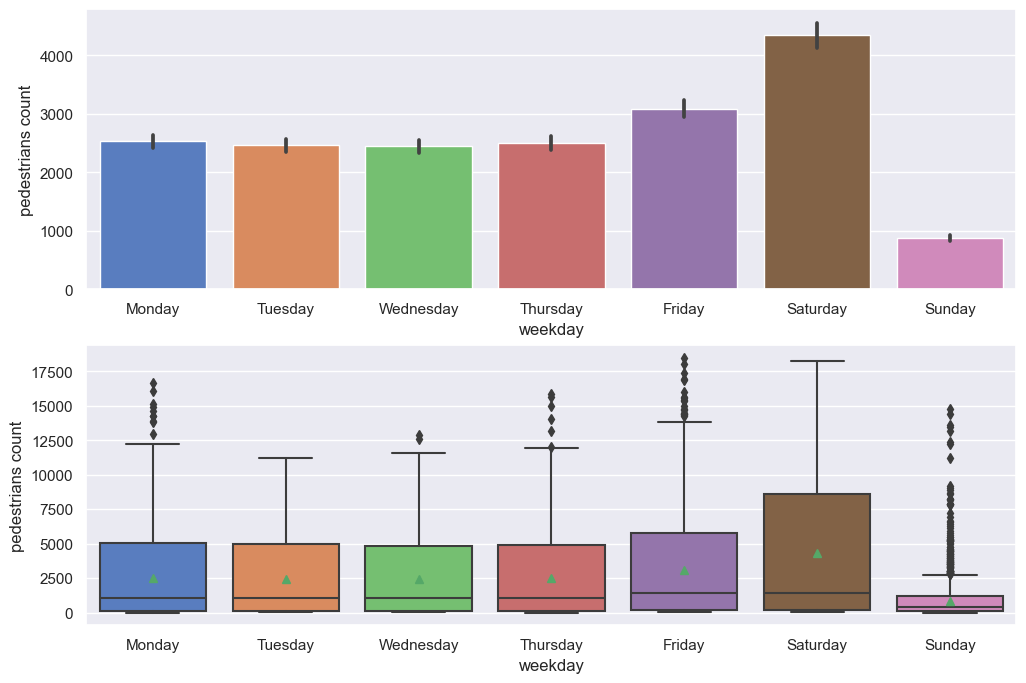

In [129]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, y="pedestrians count", x="weekday", palette="muted", ax=axs[0])
sns.boxplot(data=df_v, y="pedestrians count", x="weekday", palette="muted", ax=axs[1], showmeans=True)

plt.show()

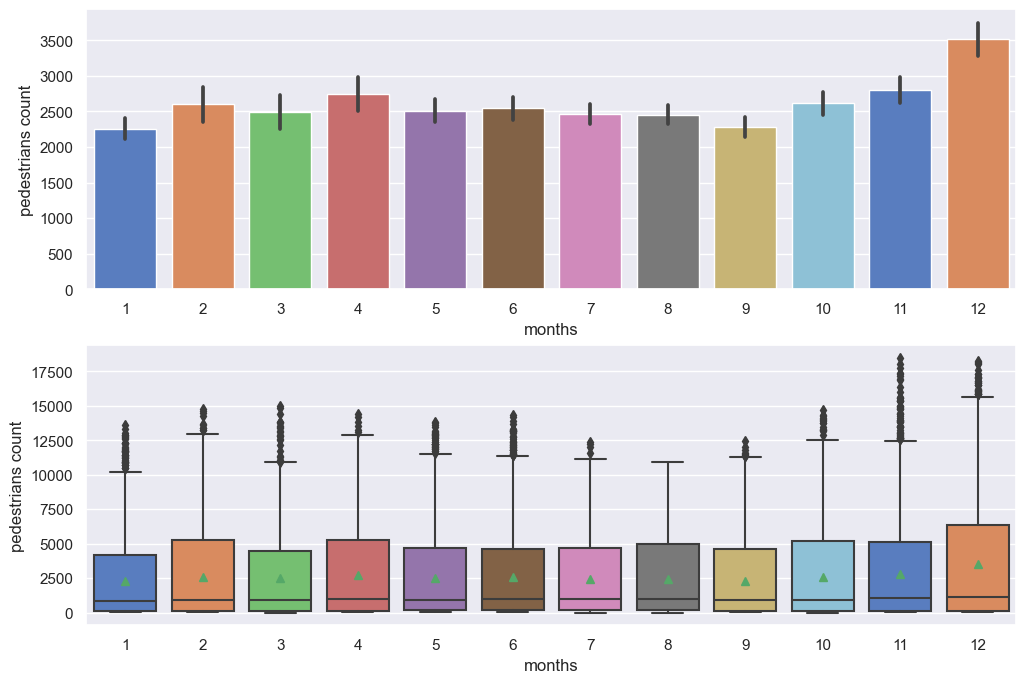

In [130]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, y="pedestrians count", x="months", palette="muted", ax=axs[0])
sns.boxplot(data=df_v, y="pedestrians count", x="months", palette="muted", ax=axs[1], showmeans=True)

plt.show()

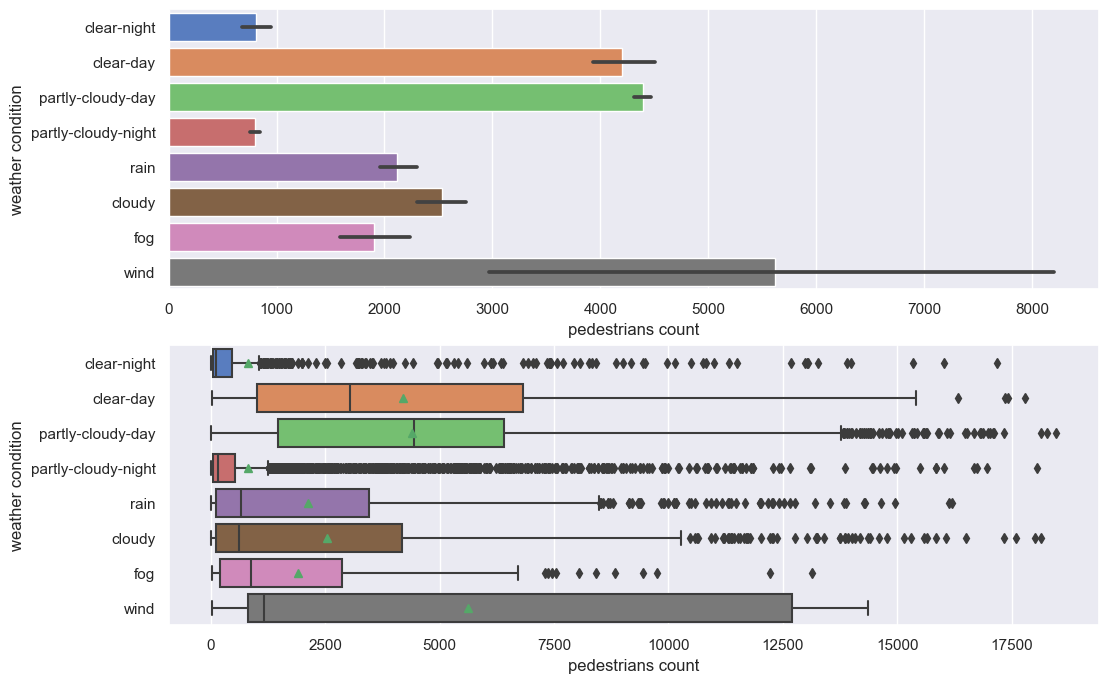

In [131]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, x="pedestrians count", y="weather condition", palette="muted", ax=axs[0]) #Plots Mean
sns.boxplot(data=df_v, x="pedestrians count", y="weather condition", palette="muted", ax=axs[1], showmeans=True) 

plt.show()

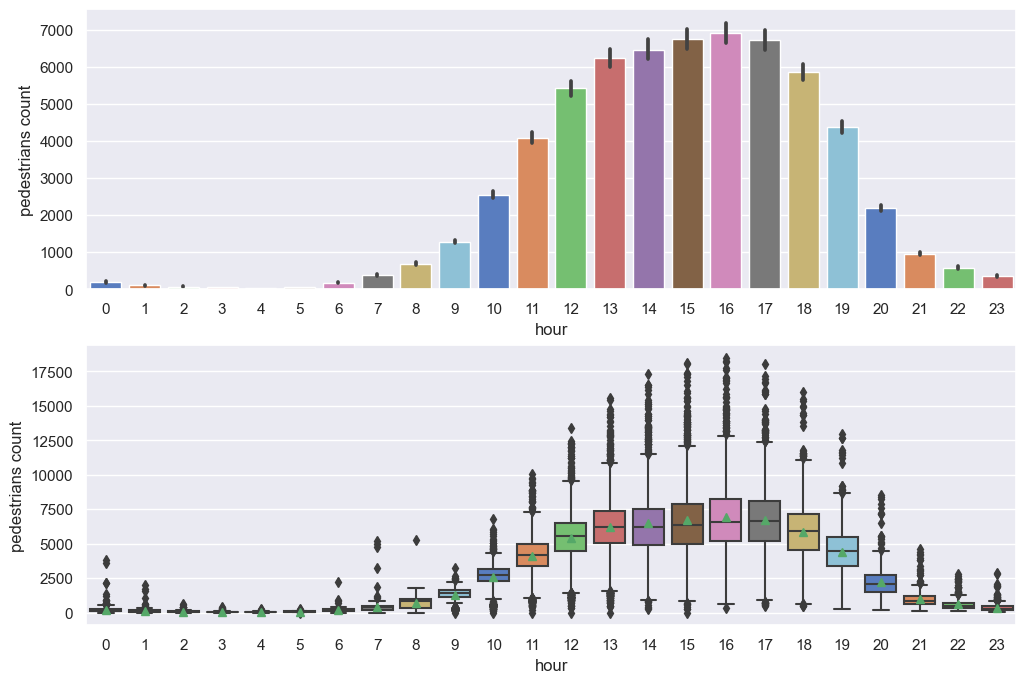

In [132]:
fig, axs = plt.subplots(2, figsize=(12, 8))
sns.barplot(data=df_v, x="hour", y="pedestrians count", palette="muted", ax=axs[0])#Plots Mean
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", ax=axs[1], showmeans=True)
plt.show()

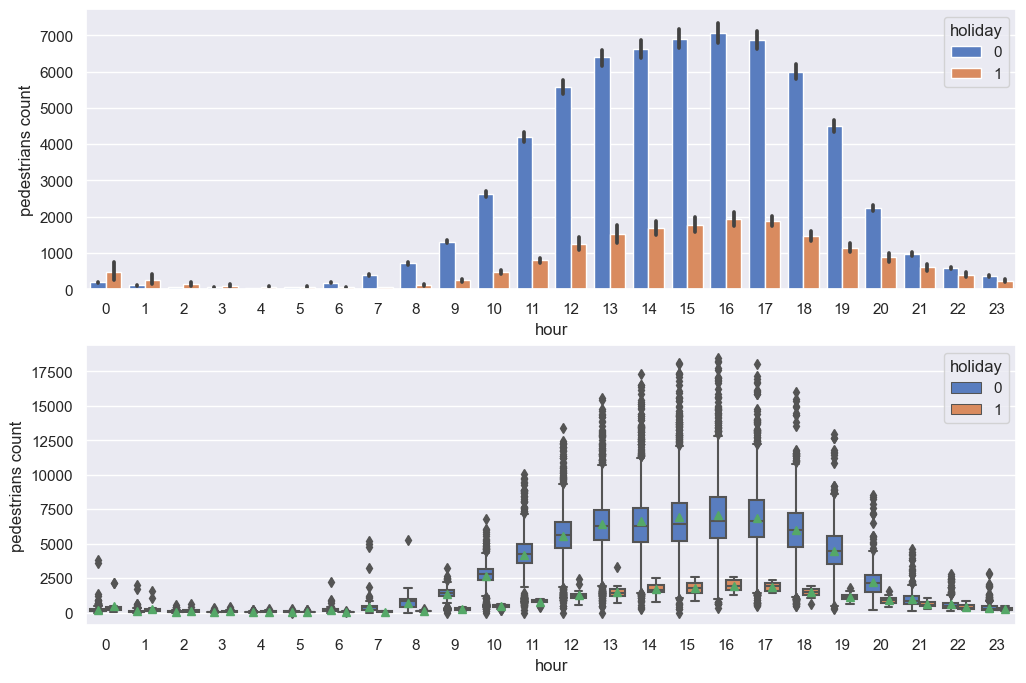

In [133]:
fig, axs = plt.subplots(2, figsize=(12,8))


sns.barplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="holiday", ax=axs[0])
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="holiday", ax=axs[1], showmeans=True)

plt.show()

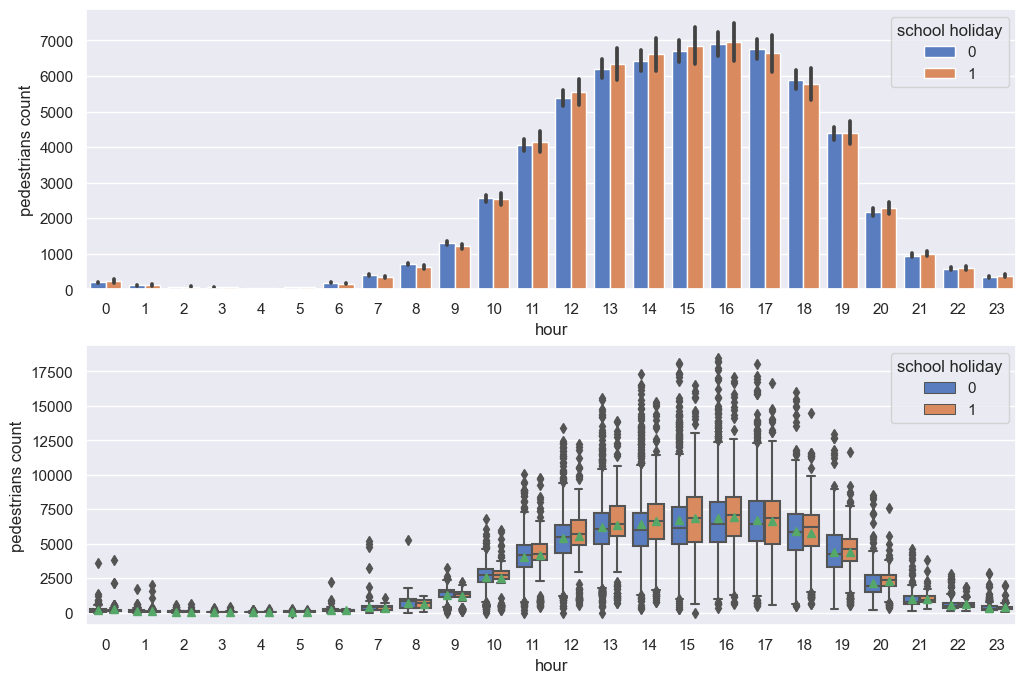

In [134]:
fig, axs = plt.subplots(2, figsize=(12,8))


sns.barplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="school holiday", ax=axs[0])
sns.boxplot(data=df_v, x="hour", y="pedestrians count", palette="muted", hue="school holiday", ax=axs[1], showmeans=True)

plt.show()

### Define Functions for easier use

In [135]:
def Xtest_smaller(Xtest, ytest, percent=0.5, min_ped=0):
    """
    Give a certain percent or minimum pedestrian condition on the entries in the Test dataset (or the train dataset) 
    to create a smaller Test dataset to do further exploratorive data analysis.

    percent: Percent of the original Dataset you want to keep on a scale between 0 and 1
    min_pred: Minimum number of pedestrians and the corresponding feautes the smaller dataset should keep

    Check to validate it works:
    1:
    Xtest_small, ytest_small = Xtest_smaller(Xtest, ytest, percent=1, min_ped=0)
    np.array_equal(ytest, ytest_small) --> True

    2:
    Xtest_small, ytest_small = Xtest_smaller(Xtest, ytest, percent=0.5, min_ped=0)
    ytest.shape[0] == ytest_small.shape[0] * 2 --> True

    3:
    Xtest_small, ytest_small = Xtest_smaller(Xtest, ytest, percent=1, min_ped=400)
    ytest_small.min() --> 400
    """

    dfXtest = pd.DataFrame(Xtest) #Create a dataframe
    dfytest = pd.DataFrame(ytest) #Create a dataframe 
    
    dfytest.index = range(dfytest.shape[0]) #set the index of the ytest dataframe to numbers from 0 to len of the dataframe 

    new_df = pd.concat([dfytest, dfXtest], axis=1) #Concat the two dataframes to create a new combined one

    if min_ped > 0: #Check if you want to restrict to a minimum number of pedestrians
        if percent == 1: #Check if you want a 100% of the entries with the minimum number of pedestrians 
            new_df_small = new_df.loc[new_df["pedestrians count"] >= min_ped]

            ytest_small = new_df_small["pedestrians count"]
            Xtest_small = new_df_small[new_df_small.columns[1:49]]
        if percent != 1: #Check if you don't want a 100% of the entries
            new_df_small = new_df.loc[new_df["pedestrians count"] >= min_ped]

            df_ytest_small = new_df_small["pedestrians count"]
            df_Xtest_small = new_df_small[new_df_small.columns[1:49]]

            #Split the dataset into two parts with the test_size determined by the percent of entries you want to keep
            Xtrain_small, Xtest_small, ytrain_small, ytest_small  = train_test_split( 
                df_Xtest_small, df_ytest_small, test_size=percent, random_state=72)
    else: #If you only want to split the original dataset into a smaller one on a percentage basis (without a minimum number of pedestrians)
        df_ytest_small = new_df["pedestrians count"]
        df_Xtest_small = new_df[new_df.columns[1:49]]
        
        #Split the dataset into two parts with the test_size determined by the percent of entries you want to keep
        Xtrain_small, Xtest_small, ytrain_small, ytest_small  = train_test_split(
            df_Xtest_small, df_ytest_small, test_size=percent, random_state=72)
    
    if percent == 1 and min_ped==0: #If you dont want a smaller dataset (idk, reduce possible mistakes)
       Xtest_small = dfXtest #So to_numpy() works in the return statement
       ytest_small = ytest


    return Xtest_small.to_numpy(), ytest_small #Turn dataframe to numpy array in order to perfom mathematical operations


In [161]:

from tensorflow import keras
#Function two quickly define two callbacks with certain parameters
def def_callbacks(stope_p = 10, reducelr_p=5, reducelr_lr=0.00001): #Use standard values when now argument is give n
    """
    stop_early patience = 10
    reduce_lr patience =5, reducelr learning rate=0.00001)
    """
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=stope_p) #Stop early stops the model fit once the Mean average error on the validation data doesn't improve after a certain amout of epochs 
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2, #Reduce the learning rate, by a factor of 0.2, when the Mean average error doesn't improve after a certain amout of epochs 
                              patience=reducelr_p, min_lr=reducelr_lr)
    callbacks_list = [stop_early,reduce_lr]
    return callbacks_list
    

### Baseline Model with Tensorflow

In [162]:
from tensorflow.keras import layers
from tensorflow import keras

In [163]:
#Define Baseline Neural Network model

#Create a Keras Sequential class to hold the different layers of our Neural Network
model = keras.Sequential()

model.add(keras.Input(shape=X.shape[1])) #Add a Input layer and define the Input shape of it (which is the column lenght of the feature Dataset X)
model.add(layers.Dense(100, activation="relu")) #Add a Hidden layer with 100 neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
model.add(layers.Dense(50, activation="relu")) #Add a second Hidden layer with 50 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 50 neurones with Dense. 
model.add(layers.Dense(50, activation="relu")) #Add a third Hidden layer with 50 neurones with Dense. 
model.add(layers.Dense(25, activation="relu")) #Add a fourth Hidden layer with 25 neurones with Dense. 
model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 10 neurones with Dense. 
model.add(layers.Dense(10, activation="relu")) #Add a fourth Hidden layer with 10 neurones with Dense. 
model.add(layers.Dense(1, activation="relu")) # Add a output layer with 1 Neuron because we only have one output --> predicted pedestrian count

model.summary()#Display an overview of the model 


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 100)               4900      
                                                                 
 dense_52 (Dense)            (None, 50)                5050      
                                                                 
 dense_53 (Dense)            (None, 50)                2550      
                                                                 
 dense_54 (Dense)            (None, 50)                2550      
                                                                 
 dense_55 (Dense)            (None, 25)                1275      
                                                                 
 dense_56 (Dense)            (None, 10)                260       
                                                                 
 dense_57 (Dense)            (None, 10)               

In [164]:

#Specify the training configuration for the Neural Network
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Optimizer that minimizes our loss function (f.e SGD or Adam) with a learning rate of 0.001
    loss=keras.losses.mae,  # Loss function the Optimizer minimizes --> Mean absolute error 
    metrics=["mae", "mse"], # List of metrics to monitor
)


#Fit the model an the training data and use a validation split for ###???Cross validation????#####
history = model.fit(
    Xtrain, # Fit the model on the train data 
    ytrain, #The target variable used to calculate the mean absolut error between the target variable and the predictions of the model 
    #batch_size=64, #Dataset will be divided into batches with 64 samples and will be updated after each batch size accordingly
    epochs=250, # 1 epoch is one training iteration - for each epoch the Neural Network processes the entire training data and updates the weights 
    callbacks = def_callbacks(25), #Stop training when training is no longer improving Mean absolute error of the validation data (20% of the training data) within 20 epochs(--> def_callbacks Function)
    validation_split=0.2, #Reserve 20% of the training data for validation at the end of each epoch, to prevent overfitting
)

Epoch 1/250


2022-11-28 11:28:13.187674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 1590.7019 - mae: 1590.7019 - mse: 7761969.5000

2022-11-28 11:28:17.154887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 5s 15ms/step - loss: 1590.7019 - mae: 1590.7019 - mse: 7761969.5000 - val_loss: 707.2203 - val_mae: 707.2203 - val_mse: 1773765.7500 - lr: 0.0010
Epoch 2/250
269/269 [==============================] - 3s 12ms/step - loss: 629.4125 - mae: 629.4125 - mse: 1476305.6250 - val_loss: 517.1132 - val_mae: 517.1132 - val_mse: 1101700.2500 - lr: 0.0010
Epoch 3/250
269/269 [==============================] - 3s 12ms/step - loss: 488.3194 - mae: 488.3194 - mse: 1024716.8125 - val_loss: 446.2976 - val_mae: 446.2976 - val_mse: 878414.8750 - lr: 0.0010
Epoch 4/250
269/269 [==============================] - 3s 11ms/step - loss: 424.5594 - mae: 424.5594 - mse: 875819.6875 - val_loss: 400.6350 - val_mae: 400.6350 - val_mse: 803406.8125 - lr: 0.0010
Epoch 5/250
269/269 [==============================] - 3s 9ms/step - loss: 394.6344 - mae: 394.6344 - mse: 795262.4375 - val_loss: 414.1808 - val_mae: 414.1808 - val_mse: 813063.5000 - lr: 0.0010
Epoch 6/250
269/269 [

### Model evaluation

In [11]:
# Evaluate the model on the test data using `evaluate` result is the corresponding loss functin (MAE), MAE and MSE (Metrics defined the model configuration)
print("Evaluation on the Test data")
results = model.evaluate(Xtest, ytest)
results_train = model.evaluate(Xtrain, ytrain)
print("Test data loss(MAE), Test data MAE, Test data MSE:", results)
print("Train data loss(MAE), Train data MAE, Train data MSE:", results_train)

Evaluation on the Test data
336/336 [==============================] - 2s 5ms/step - loss: 263.5525 - mae: 263.5525 - mse: 537452.8750
Test data loss(MAE), Test data MAE, Test data MSE: [313.2236633300781, 313.2236633300781, 482709.0625]
Train data loss(MAE), Train data MAE, Train data MSE: [263.5524597167969, 263.5524597167969, 537452.875]


In [12]:
#Create a function that evaluates the model and saves the results in a dataframe for comparisson with the Hypertuned models
def evaluate_model(model, Xtest, ytest): #Evaluate the Model on the Test data
    eval_dict = model.evaluate(Xtest, ytest, return_dict=True) #Create a dictionary to stoe the results 
    
    display_df = pd.DataFrame([eval_dict.values()], columns=[list(eval_dict.keys())]) #Create a dataframe out of the dictionary 
    
    return display_df

# Evaluate basemodel on Test Data with the above created function
results_comparisson = evaluate_model(model, Xtest, ytest) 

#Set the index as 'Basemodel
results_comparisson.index = ["Basemodel"]

# Display results
results_comparisson.head()

144/144 [==============================] - 1s 6ms/step - loss: 313.2237 - mae: 313.2237 - mse: 482709.0625


,loss,mae,mse
Basemodel,313.223663,313.223663,482709.0625


### Visualize the Model performance

  1/144 [..............................] - ETA: 31s

2022-11-28 11:27:56.966152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


144/144 [==============================] - 1s 3ms/step


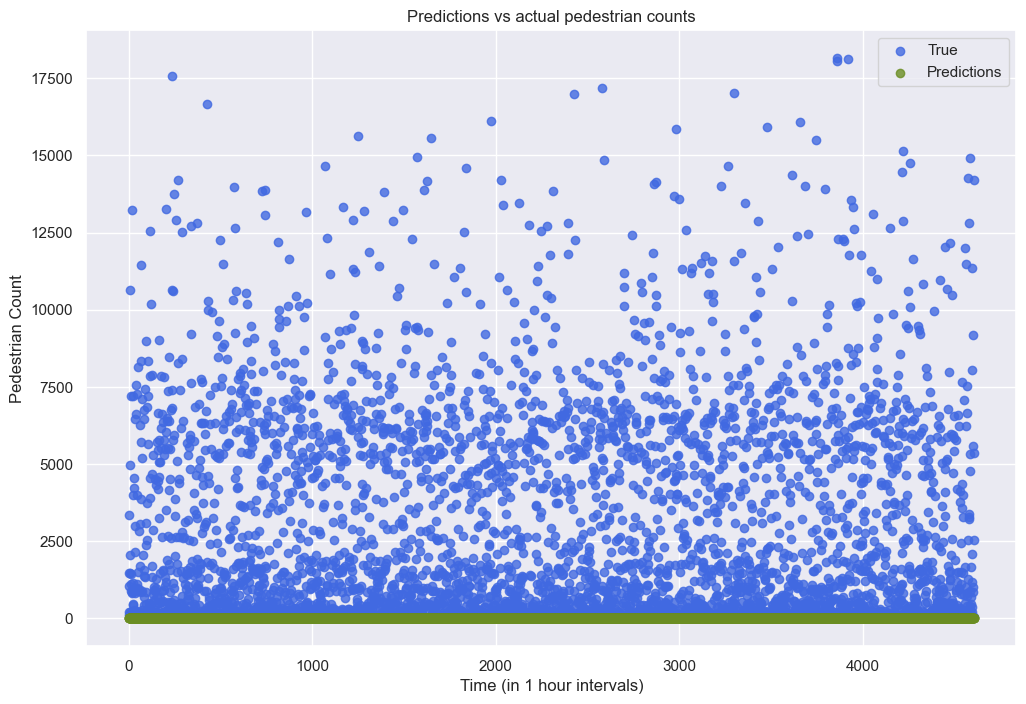

In [160]:
#Visualize the results predictions vs actual pedestrian counts
#Create a sequenze from 0 to the row lenght of the test data in order to plot
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual pedestrian count
ypred = model.predict(Xtest)


fig, axs = plt.subplots(figsize=(12, 8))

axs.scatter(xs, ytest, color ='royalblue', alpha=0.8, label="True") #Plot the actual pedestrian count 
axs.scatter(xs, ypred, color ='olivedrab', alpha=0.8, label="Predictions") #Plot the predicted pedestrian count 
axs.set_title('Predictions vs actual pedestrian counts')
axs.set_ylabel('Pedestrian Count')
axs.set_xlabel('Time (in 1 hour intervals)')
axs.legend(loc='upper right')

144/144 [==============================] - 1s 6ms/step - loss: 313.2237 - mae: 313.2237 - mse: 482709.0625


Text(109.87499999999999, 0.5, 'MAE')

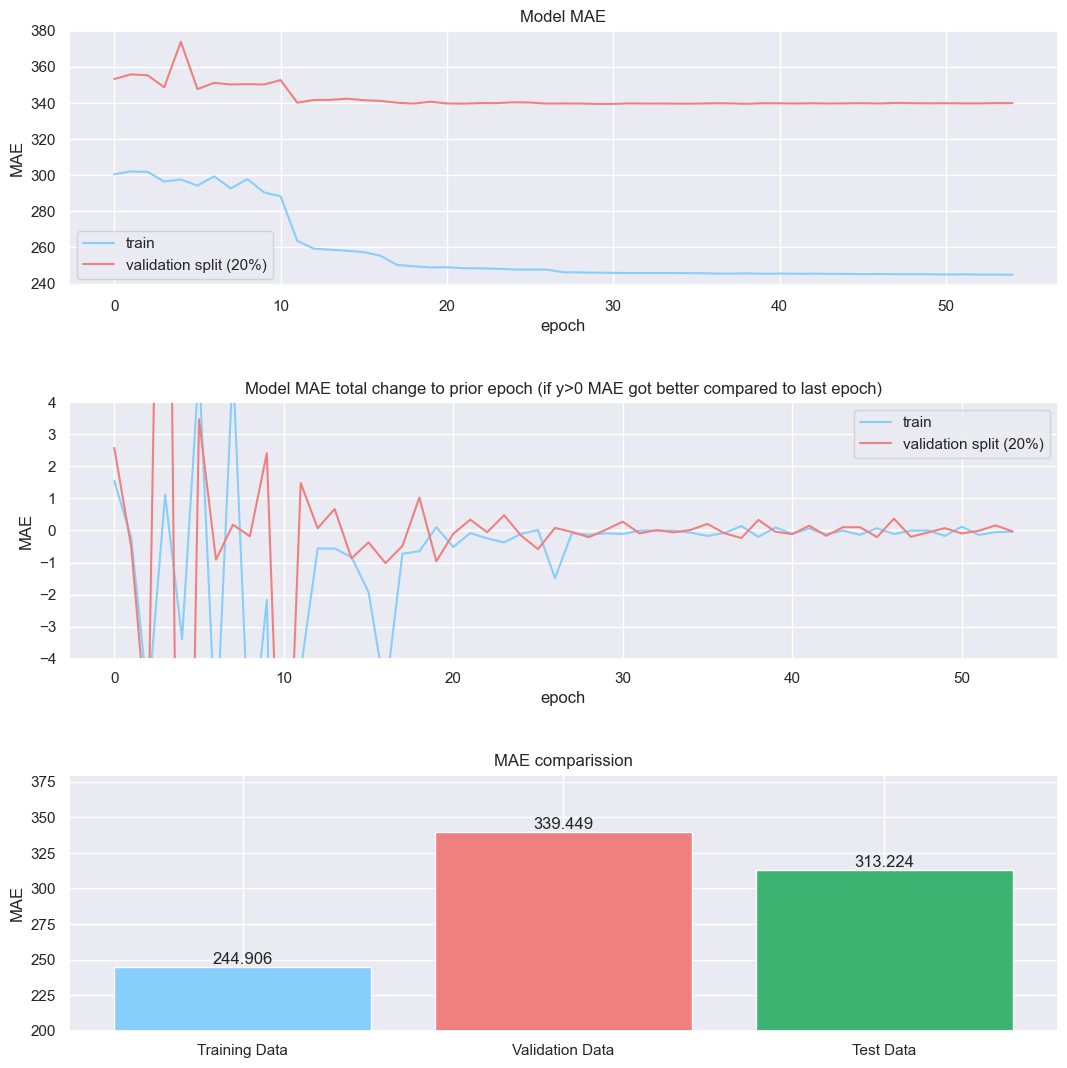

In [81]:
#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(3, figsize=(12, 12))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['mae'], label="train", color="lightskyblue")
axs[0].plot(history.history['val_mae'], label="validation split (20%)", color="lightcoral")
axs[0].set_title('Model MAE')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='lower left')


len_epoch = len(history.history["mae"]) #How many total epochs
#Compare the MAE of the Test Data with the one in the prior epoch and take the difference to see if it got better 
dif_train = [history.history["mae"][1+l] - history.history["mae"][0+l] for l in range(len_epoch-1)] 
#Compare the MAE of the Validation Data with the one in the prior epoch and take the difference to see if it got better 
dif_val = [history.history["val_mae"][1+l] - history.history["val_mae"][0+l] for l in range(len_epoch-1)] 

axs[1].plot(dif_train, label="train", color="lightskyblue")
axs[1].plot(dif_val, label="validation split (20%)", color="lightcoral")
axs[1].set_title('Model MAE total change to prior epoch (if y>0 MAE got better compared to last epoch)')
axs[1].set_ylabel('MAE')
axs[1].set_xlabel('epoch')
axs[1].legend(loc='upper right')
axs[1].set_ylim([-4, 4])

f_mae = history.history["mae"]
f_val_mae = history.history["val_mae"]
f_test_mae = model.evaluate(Xtest, ytest)

axs[2].bar("Training Data",min(f_mae), color="lightskyblue") #Display minimum mae of the training data set
axs[2].bar("Validation Data", min(f_val_mae), color="lightcoral")#Display minimum mae of the validation data set
axs[2].bar("Test Data", f_test_mae[0], color="mediumseagreen")#Display mae of the test data set
axs[2].bar_label(axs[2].containers[0], label_type='edge')
axs[2].bar_label(axs[2].containers[1], label_type='edge')
axs[2].bar_label(axs[2].containers[2], label_type='edge')
axs[2].set_ylim([200, 380])
axs[2].set_title('MAE comparission')
axs[2].set_ylabel('MAE')


#### Nur für die Besprechung

144/144 [==============================] - 1s 6ms/step - loss: 313.2237 - mae: 313.2237 - mse: 482709.0625


([<matplotlib.axis.XTick at 0x29b022f20>,
 [Text(0.2, 0, 'Training Data'),
  Text(1.2, 0, 'Validation Data'),
  Text(2.2, 0, 'Test Data')])

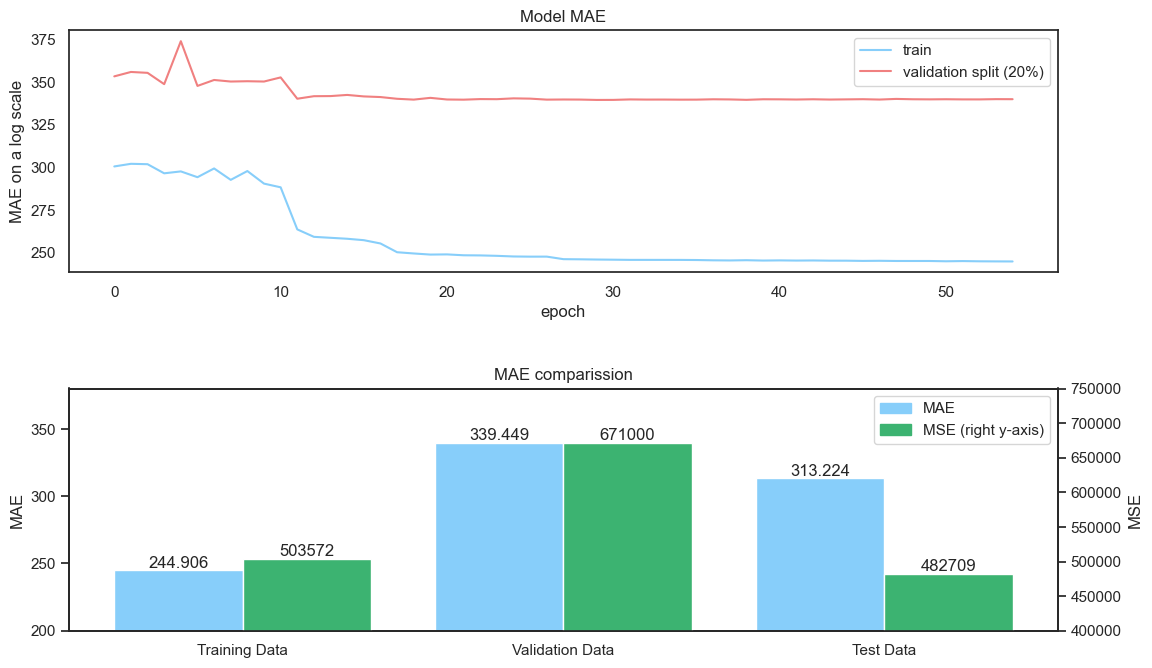

In [16]:
import matplotlib.patches as mpatches

#Plot the MAE and MSE on the training data against the validation split of the Training data over time 
sns.set(style="white") #Set style back to white because there are some visual errors with the darkgrid and the second y axis (twinx axis)

fig, axs = plt.subplots(2, figsize=(12, 8))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['mae'], label="train", color="lightskyblue")
axs[0].plot(history.history['val_mae'], label="validation split (20%)", color="lightcoral")
axs[0].set_title('Model MAE')
axs[0].set_ylabel('MAE on a log scale')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')


f_mae = history.history["mae"]
f_val_mae = history.history["val_mae"]
f_test_mae = model.evaluate(Xtest, ytest)


axs4 = axs[1].twinx()

x_axis = np.arange(3)

nameofdata = ["Training Data","Validation Data","Test Data"]

f_mse = history.history["mse"]
f_val_mse = history.history["val_mse"]


axs[1].bar(x_axis[0],min(f_mae), color="lightskyblue", width=0.4) #Display minimum mae of the training data set
axs[1].bar(x_axis[1], min(f_val_mae), color="lightskyblue", width=0.4)#Display minimum mae of the validation data set
axs[1].bar(x_axis[2], f_test_mae[0], color="lightskyblue", width=0.4)#Display mae of the test data set

axs[1].bar_label(axs[1].containers[0], label_type='edge')
axs[1].bar_label(axs[1].containers[1], label_type='edge')
axs[1].bar_label(axs[1].containers[2], label_type='edge')

axs[1].set_ylim([200, 380])
axs[1].set_title('MAE comparission')
axs[1].set_ylabel('MAE')


axs4.bar(x_axis[0] +0.4, min(f_mse), color="mediumseagreen", width=0.4)
axs4.bar(x_axis[1]+0.4, min(f_val_mse), color="mediumseagreen", width=0.4,)
axs4.bar(x_axis[2]+0.4, f_test_mae[2], color="mediumseagreen", width=0.4,)
axs4.set_ylabel('MSE')

axs4.bar_label(axs4.containers[0], label_type='edge')
axs4.bar_label(axs4.containers[1], label_type='edge')
axs4.bar_label(axs4.containers[2], label_type='edge')
axs4.set_ylim([400000, 750000])




#Custom Legend
leg_mae = mpatches.Patch(color='lightskyblue', label='MAE')
leg_mse = mpatches.Patch(color='mediumseagreen', label='MSE (right y-axis)')

axs[1].legend(handles=[leg_mae, leg_mse])

plt.xticks(x_axis + 0.2,nameofdata)

### Hyperparamter tuning 

In [38]:
import keras_tuner as kt

#### Tuning Optimzer, learning rate and activation function (Hyperparameter)
##### This approach is used to reduce the computing time. A better way would be to build a larger model where the tuner would tune the optimizer, number of layers and number on nodes at the same time

In [165]:
#Find the best Optimizer, activation fucntion and learning rate for the baseline model 
def h1_model_builder(hp): 
 
#Create a Keras Sequential class to hold the different layers of our Neural Network
    model = keras.Sequential()

    #Tune activation function
    hp_activation = hp.Choice('activation', values=['relu', 'tanh']) #Define a Hyperparameter as a choiche (option) for different activation functions. The tuner will try these to find the best possible for the baseline model 

    model.add(keras.layers.Flatten()) #Add a Input layer and use flatten to get a 1 dimensional input!!!!
    model.add(layers.Dense(100, activation=hp_activation)) #Add a Hidden layer with 100 Neurones with Dense. Dense takes the output from our Input layer applies a weight matrix and than applies a activation function (in this case relu).
    model.add(layers.Dense(50, activation=hp_activation)) #Add a second Hidden layer with 50 Neurones with Dense. Dense takes the output from our first hidden layer applies a weight matrix and than applies a activation function (in this case relu).
    model.add(layers.Dense(50, activation=hp_activation)) #Add a third Hidden layer with 50 Neurones with Dense. 
    model.add(layers.Dense(50, activation=hp_activation)) #Add a third Hidden layer with 50 Neurones with Dense. 
    model.add(layers.Dense(25, activation=hp_activation)) #Add a fourth Hidden layer with 25 Neurones with Dense. 
    model.add(layers.Dense(10, activation=hp_activation)) #Add a fourth Hidden layer with 10 Neurones with Dense. 
    model.add(layers.Dense(10, activation=hp_activation)) #Add a fourth Hidden layer with 10 Neurones with Dense. 
    model.add(layers.Dense(1, activation=hp_activation))  #Add an output layer with activation function relu  

    #Tune learning rate 
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])  # Define a Hyperparameter as a choice to tune learning rate with the values 0.01, 0.001, 0.0001, 0.00001

    #Create a dictionary to hold the different optimization functions 
    optimizers_dict = {
        "Adam":    keras.optimizers.Adam(learning_rate=hp_learning_rate),
        "SGD":     keras.optimizers.SGD(learning_rate=hp_learning_rate),
        "Adagrad": keras.optimizers.Adagrad(learning_rate=hp_learning_rate),
        "Adadelta": keras.optimizers.Adadelta(learning_rate=hp_learning_rate),
        "RMSprop": keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
        }

    hp_optimizers = hp.Choice( #Define a Hyperparameter as a choice to tune the optimizer 
        'optimizer', values=["Adam", "SGD", "Adagrad", "Adadelta", "RMSprop"] #Options the tuner will try, that correspond to the optimizer dictionary keys 
        )


    model.compile(optimizer=optimizers_dict[hp_optimizers], #Complie the model and use the optimizer choice as input for the optimizer 
                  loss=keras.losses.mae, #Loss function is Mean average error 
                  metrics=["mae"])
    
    return model

In [168]:
#Easy tuner because we only have 5 different Optimizer options, 4 learning rate optimizations and 2 activation functions, 
# so randomly selecting is okay because no matter what we will try every combination of the 40
h1_tuner = kt.RandomSearch(hypermodel = h1_model_builder, #The model the Randomsearch tuner will tune 
                       objective = 'val_mae', #Objetive the tuner will try to minimize 
                       max_trials =45 , #The total number of trails to test at most (to try every combination it has to be at least 40 (5*4*2))
                       directory = 'kt_dir', #create a dictionary to store the tries and metrics 
                       overwrite=True, #To be able to overwrite prior tuner entries
                       project_name = 'kt_RandomSearch')

In [169]:
#Initiate the tuner with the Train data
#Tune for 10 epochs with a validation split of 20% and a possible minimum learning rate of 0.000001 for 
# the Reduce learning rate callback function
h1_tuner.search(Xtrain, ytrain, epochs=10, validation_split=0.2, callbacks=def_callbacks(reducelr_lr=0.000001)) 

Trial 8 Complete [00h 00m 31s]
val_mae: 571.4078369140625

Best val_mae So Far: 363.4703063964844
Total elapsed time: 00h 04m 21s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
tanh              |relu              |activation
0.0001            |0.001             |learning_rate
SGD               |Adam              |optimizer

Epoch 1/10


2022-11-28 11:37:28.048281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 2616.5312 - mae: 2616.5312

2022-11-28 11:37:33.032576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 7s 19ms/step - loss: 2616.5312 - mae: 2616.5312 - val_loss: 2605.4978 - val_mae: 2605.4978 - lr: 1.0000e-04
Epoch 2/10
269/269 [==============================] - 3s 11ms/step - loss: 2616.4355 - mae: 2616.4355 - val_loss: 2605.4043 - val_mae: 2605.4043 - lr: 1.0000e-04
Epoch 3/10
269/269 [==============================] - 4s 14ms/step - loss: 2616.3440 - mae: 2616.3440 - val_loss: 2605.3167 - val_mae: 2605.3167 - lr: 1.0000e-04
Epoch 4/10
269/269 [==============================] - 3s 10ms/step - loss: 2616.2588 - mae: 2616.2588 - val_loss: 2605.2351 - val_mae: 2605.2351 - lr: 1.0000e-04
Epoch 5/10
269/269 [==============================] - 3s 9ms/step - loss: 2616.1831 - mae: 2616.1831 - val_loss: 2605.1628 - val_mae: 2605.1628 - lr: 1.0000e-04
Epoch 6/10
269/269 [==============================] - 2s 9ms/step - loss: 2616.1128 - mae: 2616.1128 - val_loss: 2605.0972 - val_mae: 2605.0972 - lr: 1.0000e-04
Epoch 7/10
 55/269 [=====>...............

KeyboardInterrupt: 

In [96]:
#Create a new Model with the Hyperparameters found by the tuner
h1_best_hps = h1_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The first hyperparameter search is complete. The best optimizer is {h1_best_hps.get('optimizer')}, the best activation function is 
{h1_best_hps.get("activation")} and the optimal learning rate for the optimizer is {h1_best_hps.get('learning_rate')}.
Summary:
""")

#Display the best 10 Hypermodel configurations found by the tuner
h1_tuner.results_summary() 

#Hypertuned Model 
h1_model = h1_tuner.hypermodel.build(h1_best_hps)
#Create a new History for the model to compare it with the Baseline Histroy 
h1_history = h1_model.fit(Xtrain, ytrain, epochs=100, validation_split=0.2,
                    callbacks=def_callbacks(reducelr_lr=0.000001))


The first hyperparameter search is complete. The best optimizer is Adam, the best activation function is 
relu and the optimal learning rate for the optimizer is 0.01.
Summary:

Results summary
Results in kt_dir/kt_RandomSearch
Showing 10 best trials
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.01
optimizer: Adam
Score: 373.3028259277344
Trial summary
Hyperparameters:
activation: relu
learning_rate: 0.001
optimizer: SGD
Score: 1346.9647216796875
Trial summary
Hyperparameters:
activation: tanh
learning_rate: 0.0001
optimizer: RMSprop
Score: 2604.59716796875
Trial summary
Hyperparameters:
activation: tanh
learning_rate: 0.01
optimizer: SGD
Score: 2604.597412109375
Trial summary
Hyperparameters:
activation: tanh
learning_rate: 0.001
optimizer: SGD
Score: 2604.611572265625
Trial summary
Hyperparameters:
activation: tanh
learning_rate: 1e-05
optimizer: RMSprop
Score: 2604.6474609375
Trial summary
Hyperparameters:
activation: tanh
learning_rate: 0.001
optimizer: Adadelta

2022-11-28 11:09:42.979304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 879.8953 - mae: 879.8953

2022-11-28 11:09:46.064876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 4s 11ms/step - loss: 879.8953 - mae: 879.8953 - val_loss: 510.1432 - val_mae: 510.1432 - lr: 0.0100
Epoch 2/100
269/269 [==============================] - 2s 9ms/step - loss: 520.4839 - mae: 520.4839 - val_loss: 428.4461 - val_mae: 428.4461 - lr: 0.0100
Epoch 3/100
269/269 [==============================] - 2s 9ms/step - loss: 495.4082 - mae: 495.4082 - val_loss: 523.5663 - val_mae: 523.5663 - lr: 0.0100
Epoch 4/100
269/269 [==============================] - 2s 9ms/step - loss: 472.5811 - mae: 472.5811 - val_loss: 433.9629 - val_mae: 433.9629 - lr: 0.0100
Epoch 5/100
269/269 [==============================] - 3s 10ms/step - loss: 432.1820 - mae: 432.1820 - val_loss: 400.6693 - val_mae: 400.6693 - lr: 0.0100
Epoch 6/100
 86/269 [========>.....................] - ETA: 1s - loss: 388.4784 - mae: 388.4784

KeyboardInterrupt: 

In [ ]:
# Evaluate model on test set using the above created function to save the results in the results_comparisson dataframe
hyper_results1 = evaluate_model(h1_model, Xtest, ytest) 

# Set index to Baseline model Op/lr/af
hyper_results1.index = ["First Hypertuned model"]

# Append results in dataframe
results_comparisson = pd.concat([results_comparisson, hyper_results1])

results_comparisson.head()


144/144 [==============================] - 1s 4ms/step - loss: 297.4000 - mae: 297.4000


,loss,mae,mse
Basemodel,313.223663,313.223663,482709.0625
Baseline model Op/lr/af,294.956787,294.956787,NaN
Baseline model Op/lr/af and NL/NN,307.020538,307.020538,NaN
Baseline model Op/lr/af,297.399963,297.399963,NaN


#### Optimal number of layers and nodes
#### Find the optimal number of layers and nodes and if Dropout is benefitial or not.

In [88]:
def h2_model_builder(hp): 
 
    #Create a Keras Sequential class to hold the different layers of our Neural Network
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    
# Tune the number of hidden layers and units (Nodes)
    # Number of hidden layers: 8 - 12
    for i in range(1, hp.Int("num_layers", 6, 8)):
        
        # Number of Nodes: 32 - 512 with stepsize of 32
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=128, step=32), #Define a Hyperparameter as a integer between 32 and 128 as different amount of Nodes 
                activation="relu") #Using the best activation function found by the tuner above for the baseline model (Giving a choice and tuning it again would be likely better but much more time consuing to compute)
            )
        
    if hp.Boolean("dropout"): #Define a Hyperparameter as a Boolean value to either use or not use Dropout
        #Will randomly "droput" (deactivate) different weights (25% of total) and train the model on the remaining. After the tuning is done all weights will be keept (so no weights are actualy not used by the final mdoel)
        model.add(layers.Dropout(rate=0.25)) 
    
    
    # Add output layer
    model.add(keras.layers.Dense(units=1, activation="relu"))
    
    #Here setting a learning rate (best by above tuner on baseline model) is better/more efficient because other wise the Tuner would also have to tune the learning rate adding a huge amout of new models to try 
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
                  loss=keras.losses.mae,
                  metrics=["mae"])
    
    return model

In [89]:
# Using the Hyperband tuner which selects different Hyperparameter combinations when the have promising results after a few epochs and tunes them further
h2_tuner = kt.Hyperband(hypermodel=h2_model_builder, #Select the model that should be tuned
                     objective='val_mae', #Objective to minimize, in this case the validation split Mean average error
                     max_epochs=15, #Maximum number of epochs to train 1 model configuration 
                     hyperband_iterations=2, #the number of times to iterate over the full Hyperband algorithm
                     overwrite=True, ##To be able to overwrite prior tuner entries
                     directory='kt_dir',
                     project_name='kt_Hyperband')


In [90]:
# Execute the tuner  
h2_tuner.search(Xtrain, ytrain, epochs=15, validation_split=0.2, callbacks=def_callbacks(reducelr_lr=0.000001))

Trial 30 Complete [00h 00m 38s]
val_mae: 372.88153076171875

Best val_mae So Far: 349.8316345214844
Total elapsed time: 00h 09m 07s

Search: Running Trial #31

Value             |Best Value So Far |Hyperparameter
6                 |7                 |num_layers
64                |64                |units_1
128               |32                |units_2
64                |128               |units_3
32                |64                |units_4
32                |96                |units_5
False             |False             |dropout
32                |32                |units_6
64                |128               |units_7
2                 |15                |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |0                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


2022-11-28 11:04:14.047873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


214/269 [======================>.......] - ETA: 0s - loss: 966.0150 - mae: 966.0150

KeyboardInterrupt: 

In [94]:
#Use the best Hyperparameter to build a new model and train the model on the training Dataset

#Create a new Model with the Hyperparameters found by the tuner
h2_best_hps = h2_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The second hyperparameter search is complete. The optimal number of layers is {h2_best_hps.get('num_layers')}.
Summary:
""")

#Display the best 10 Hypermodel configurations found by the tuner
h2_tuner.results_summary()

#Hypertuned Model 
h2_model = h2_tuner.hypermodel.build(h2_best_hps)
#Create a new History for the model to compare it with the other models
h2_history = h2_model.fit(Xtrain, ytrain, epochs=150, validation_split=0.2,
                    callbacks=def_callbacks(reducelr_lr=0.000001))


The second hyperparameter search is complete. The optimal number of layers is 7.
Summary:

Results summary
Results in kt_dir/kt_hyperband1
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 7
units_1: 64
units_2: 32
units_3: 128
units_4: 64
units_5: 96
dropout: False
units_6: 32
units_7: 128
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 349.8316345214844
Trial summary
Hyperparameters:
num_layers: 8
units_1: 32
units_2: 128
units_3: 128
units_4: 128
units_5: 64
dropout: False
units_6: 96
units_7: 64
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 362.3230285644531
Trial summary
Hyperparameters:
num_layers: 7
units_1: 96
units_2: 96
units_3: 64
units_4: 64
units_5: 32
dropout: True
units_6: 64
units_7: 128
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 364.8468017578125
Trial summary
Hyperparameters:
num_layers: 7
units_1: 64
units_2: 64
units_3: 64
units_4: 32
units_5: 64
drop

2022-11-28 11:08:46.164959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - ETA: 0s - loss: 949.7182 - mae: 949.7182

2022-11-28 11:08:49.156284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


269/269 [==============================] - 4s 11ms/step - loss: 949.7182 - mae: 949.7182 - val_loss: 503.0915 - val_mae: 503.0915 - lr: 0.0100
Epoch 2/150
269/269 [==============================] - 3s 10ms/step - loss: 531.0639 - mae: 531.0639 - val_loss: 561.1006 - val_mae: 561.1006 - lr: 0.0100
Epoch 3/150
269/269 [==============================] - 2s 9ms/step - loss: 484.3955 - mae: 484.3955 - val_loss: 405.7491 - val_mae: 405.7491 - lr: 0.0100
Epoch 4/150
269/269 [==============================] - 2s 9ms/step - loss: 449.4505 - mae: 449.4505 - val_loss: 400.8273 - val_mae: 400.8273 - lr: 0.0100
Epoch 5/150
269/269 [==============================] - 3s 10ms/step - loss: 439.1643 - mae: 439.1643 - val_loss: 429.5208 - val_mae: 429.5208 - lr: 0.0100
Epoch 6/150
269/269 [==============================] - 3s 9ms/step - loss: 410.4489 - mae: 410.4489 - val_loss: 404.2127 - val_mae: 404.2127 - lr: 0.0100
Epoch 7/150
269/269 [==============================] - 3s 10ms/step - loss: 399.6740 

KeyboardInterrupt: 

In [30]:
# Evaluate model on test set using the above created function to save the results in the results_comparisson dataframe
hyper_results2 = evaluate_model(h2_model, Xtest, ytest)

# Set index to hypertuned
hyper_results2.index = ["Second Hypertuned model"]

# Append results in dataframe
results_comparisson = pd.concat([results_comparisson, hyper_results2])

results_comparisson.head()



144/144 [==============================] - 1s 6ms/step - loss: 307.0205 - mae: 307.0205


,loss,mae,mse
Basemodel,313.223663,313.223663,482709.0625
Baseline model Op/lr/af,294.956787,294.956787,NaN
Baseline model Op/lr/af and NL/NN,307.020538,307.020538,NaN


### Evaluate and Viusalize the Hypertuned Model 

144/144 [==============================] - 0s 2ms/step


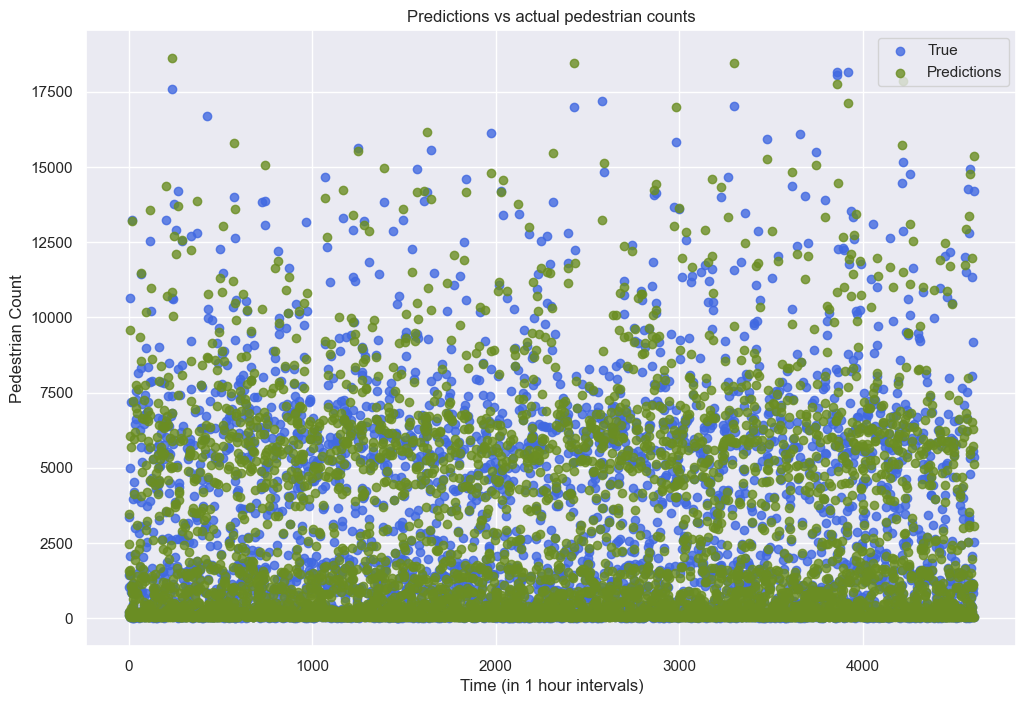

In [159]:
#Visualize the results predictions vs actual values
#Create a sequenze from 0 to the row lenght of the test data in order to plot
xs = np.linspace(0, ytest.shape[0], num=ytest.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual values
yhpred = h2_model.predict(Xtest) #Predict the pedestrian count with the final Hypertuned model

fig, axs = plt.subplots(figsize=(12, 8))

axs.scatter(xs, ytest, color ='royalblue', alpha=0.8, label="True")
axs.scatter(xs, yhpred, color ='olivedrab', alpha=0.8, label="Predictions")
axs.set_title('Predictions vs actual pedestrian counts')
axs.set_ylabel('Pedestrian Count')
axs.set_xlabel('Time (in 1 hour intervals)')
axs.legend(loc='upper right')

144/144 [==============================] - 1s 5ms/step - loss: 307.0205 - mae: 307.0205


Text(109.87499999999999, 0.5, 'MAE')

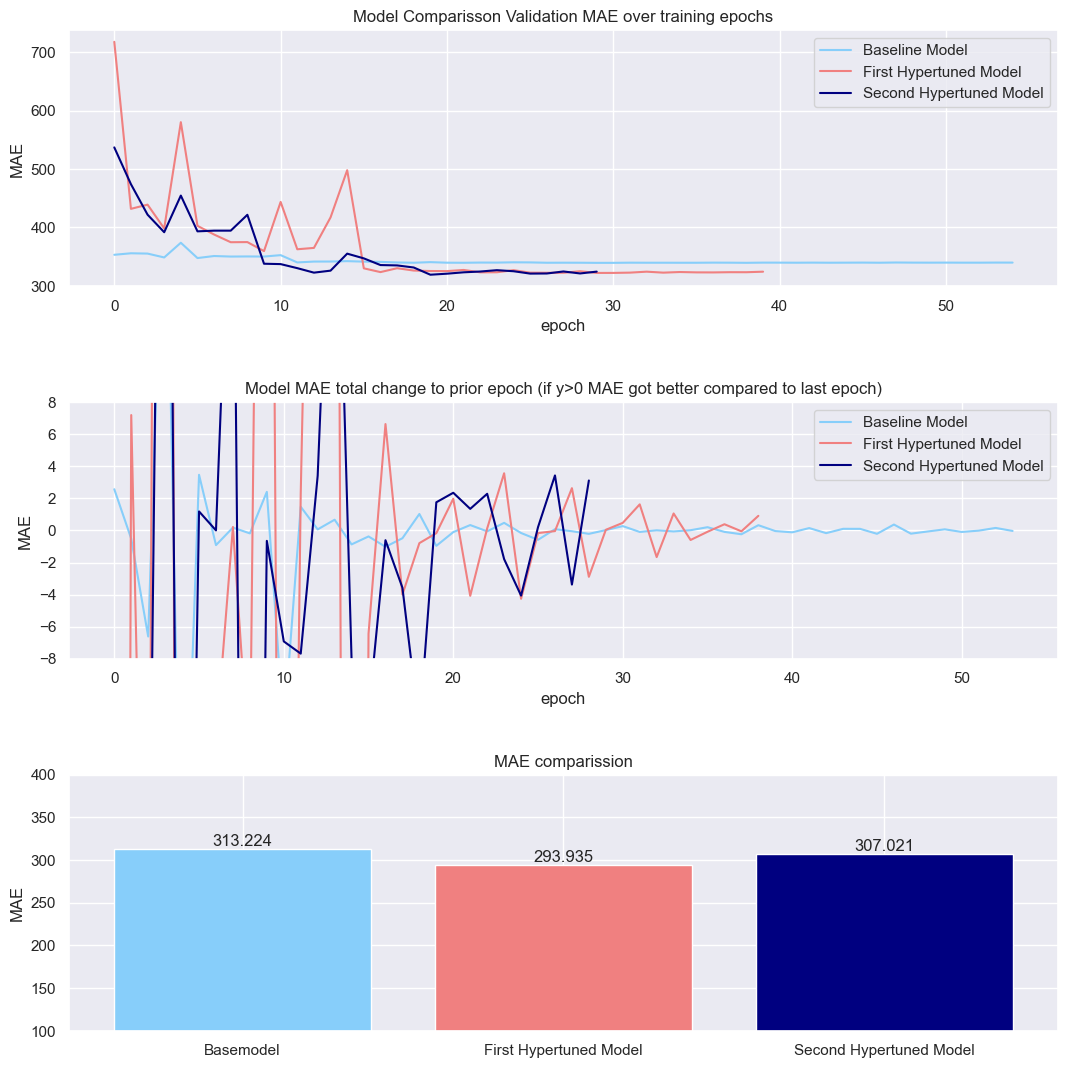

In [80]:
#Plot the MAE on the training data against the validation split of the Training data over time 
#history.history.keys()

fig, axs = plt.subplots(3, figsize=(12, 12))

fig.tight_layout(pad=5.0)

axs[0].plot(history.history['val_mae'], label="Baseline Model", color="lightskyblue")
axs[0].plot(h1_history.history['val_mae'], label="First Hypertuned Model", color="lightcoral")
axs[0].plot(h2_history.history['val_mae'], label="Second Hypertuned Model", color="Navy")
axs[0].set_title('Model Comparisson Validation MAE over training epochs')
axs[0].set_ylabel('MAE')
axs[0].set_xlabel('epoch')
axs[0].legend(loc='upper right')

len_epoch = len(history.history["mae"]) #How many total epochs with the Baseline Model
h1_len_epoch = len(h1_history.history["mae"]) #How many total epochs with the first Hypertuned Model
h2_len_epoch = len(h2_history.history["mae"]) #How many total epochs with the second Hypertuned Model

#Baseline Model: Compare the MAE of the Validation Data with the one in the prior epoch and take the difference to see if it got better 
dif_val = [history.history["val_mae"][1+l] - history.history["val_mae"][0+l] for l in range(len_epoch-1)] 
#First Hypertuned Model: Compare the MAE of the Validation Data with the one in the prior epoch and take the difference to see if it got better 
h1_dif_val = [h1_history.history["val_mae"][1+l] - h1_history.history["val_mae"][0+l] for l in range(h1_len_epoch-1)] 
#Second Hypertuned Model: Compare the MAE of the Validation Data with the one in the prior epoch and take the difference to see if it got better 
h2_dif_val = [h2_history.history["val_mae"][1+l] - h2_history.history["val_mae"][0+l] for l in range(h2_len_epoch-1)] 


 
axs[1].plot(dif_val, label="Baseline Model", color="lightskyblue")
axs[1].plot(h1_dif_val, label="First Hypertuned Model", color="lightcoral")
axs[1].plot(h2_dif_val, label="Second Hypertuned Model", color="navy")
axs[1].set_title('Model MAE total change to prior epoch (if y>0 MAE got better compared to last epoch)')
axs[1].set_ylabel('MAE')
axs[1].set_xlabel('epoch')
axs[1].legend(loc='upper right')
axs[1].set_ylim([-8, 8])



base_mae = model.evaluate(Xtest, ytest)
hp1_mae = h1_model.evaluate(Xtest, ytest)
hp2_mae = h2_model.evaluate(Xtest, ytest)


axs[2].bar("Basemodel", base_mae[0], color="lightskyblue" )
axs[2].bar("First Hypertuned Model", hp1_mae[0], color="lightcoral")
axs[2].bar("Second Hypertuned Model", hp2_mae[0], color="navy")
axs[2].bar_label(axs[2].containers[0], label_type='edge')
axs[2].bar_label(axs[2].containers[1], label_type='edge')
axs[2].bar_label(axs[2].containers[2], label_type='edge')
axs[2].set_ylim([100, 400])
axs[2].set_title('MAE comparission')
axs[2].set_ylabel('MAE')

3/3 [==============================] - 0s 7ms/step


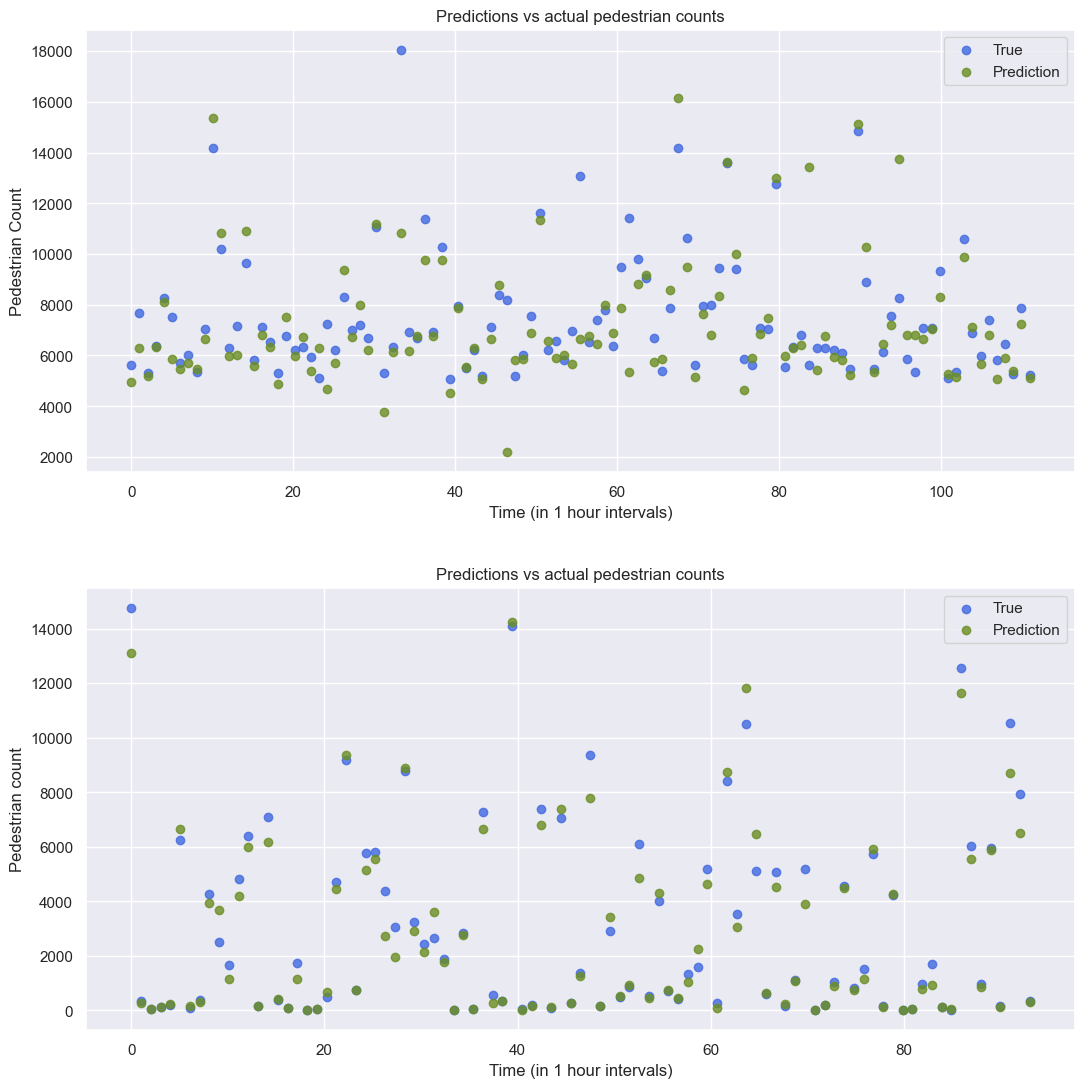

In [157]:
#Create a smaller Xtest to visualize the predictions and actual values better

Xtest_smaller1, ytest_smaller1 = Xtest_smaller(Xtest, ytest, percent=0.1, min_ped=5000)
Xtest_smaller2, ytest_smaller2 = Xtest_smaller(Xtest, ytest, percent=0.02, min_ped=0)

#Visualize the results predictions vs actual values
#Create a sequenze from 0 to the row lenght of the smaller test data in order to plot
xs1 = np.linspace(0, ytest_smaller1.shape[0], num=ytest_smaller1.shape[0])
xs2 = np.linspace(0, ytest_smaller2.shape[0], num=ytest_smaller2.shape[0])

#Using the Neural Network to predict the Pedestrian count for our Xtest set in order to plot it against the actual values
yhpred_smaller1 = h2_model.predict(Xtest_smaller1) #Predict the pedestrian count with the final Hypertuned model
yhpred_smaller2 = h2_model.predict(Xtest_smaller2) #Predict the pedestrian count with the final Hypertuned model

fig, axs = plt.subplots(2, figsize=(12, 12))

fig.tight_layout(pad=5.0)

axs[0].scatter(xs1, ytest_smaller1, color ='royalblue', alpha=0.8, label="True")
axs[0].scatter(xs1, yhpred_smaller1, color ='olivedrab', alpha=0.8, label="Prediction")
axs[0].set_title('Predictions vs actual pedestrian counts')
axs[0].set_ylabel('Pedestrian Count')
axs[0].set_xlabel('Time (in 1 hour intervals)')
axs[0].legend(loc='upper right')

axs[1].scatter(xs2, ytest_smaller2, color ='royalblue', alpha=0.8, label="True")
axs[1].scatter(xs2, yhpred_smaller2, color ='olivedrab', alpha=0.8, label="Prediction")
axs[1].set_title('Predictions vs actual pedestrian counts')
axs[1].set_ylabel('Pedestrian count')
axs[1].set_xlabel('Time (in 1 hour intervals)')
axs[1].legend(loc='upper right')
